YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_10044\3690919998.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


              TSLA          BND          SPY
count  2535.000000  2535.000000  2535.000000
mean     69.289450   316.067402   117.848209
std       4.792147   117.926910   116.508288
min      61.860886   156.800873     9.578000
25%      65.565266   214.841988    17.228000
50%      68.329124   277.117920    30.298000
75%      72.879948   405.869202   221.525002
max      78.823288   609.750000   479.859985
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-01-02 to 2025-01-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    2535 non-null   float64
 1   BND     2535 non-null   float64
 2   SPY     2535 non-null   float64
dtypes: float64(3)
memory usage: 79.2 KB
None


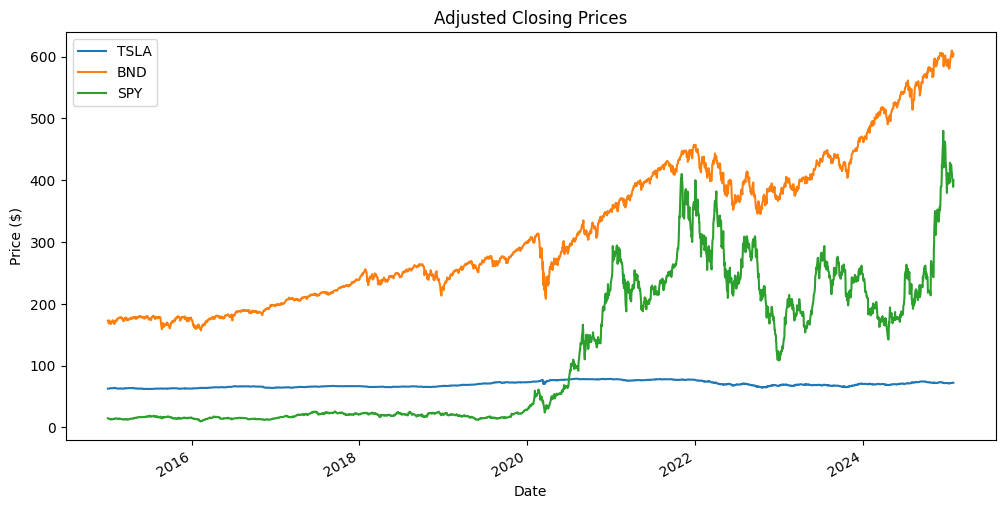

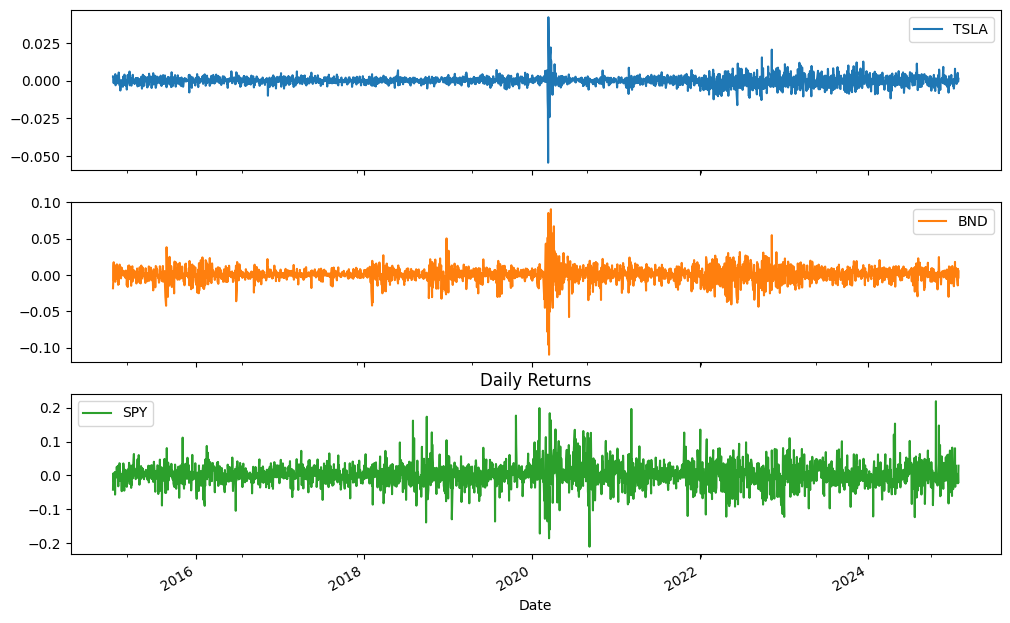

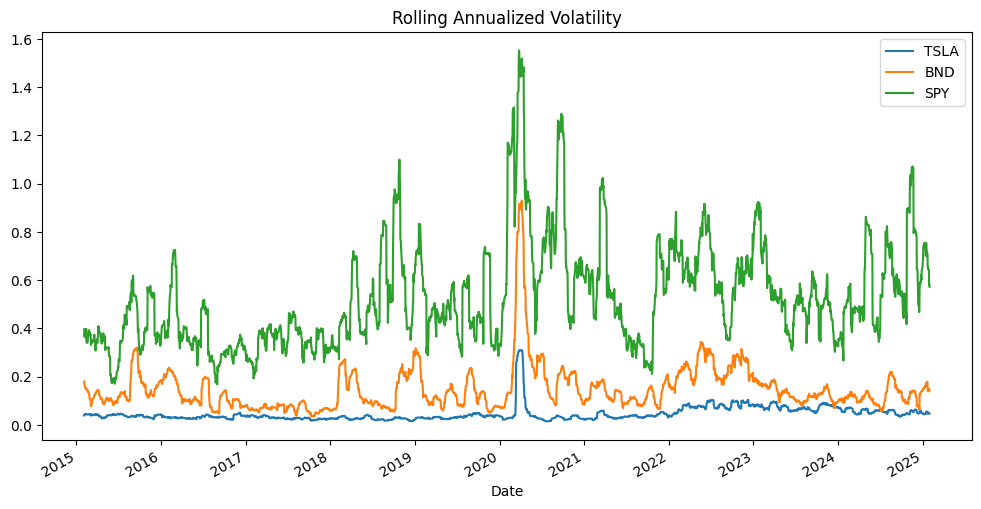

Outliers:
                 TSLA       BND       SPY
Date                                    
2020-03-12 -0.054385 -0.095677 -0.116172
2020-03-16  0.010511 -0.109424 -0.185778
2020-03-18 -0.024140 -0.050633 -0.160344


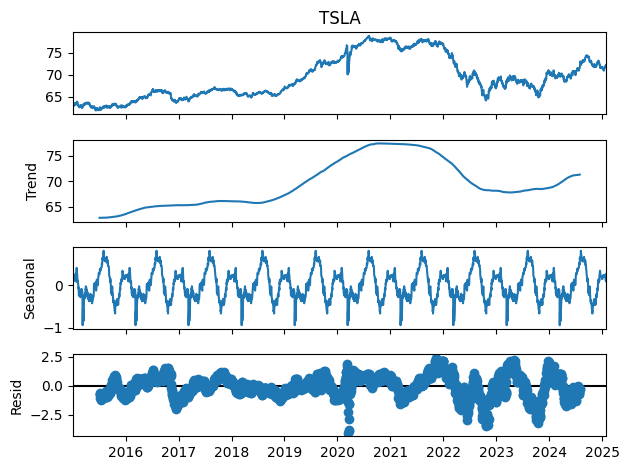

TSLA VaR (95%): -0.48%
Sharpe Ratios:
 TSLA    0.288983
BND     0.797519
SPY     0.860690
dtype: float64


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Fetch data
tickers = ['TSLA', 'BND', 'SPY']
#data = yf.download(tickers, period="1y")  # Download data for the past year
data = yf.download(tickers, start='2015-01-01', end='2025-01-31')
# Check if 'Adj Close' is in the columns
if 'Adj Close' in data.columns:
    # If it is, select only 'Adj Close' and rename columns
    data = data[['Adj Close']]
    data.columns = tickers
else:
    # If not, check if there are other relevant columns
    # like 'Close' or 'Adjusted Close'
    if 'Close' in data.columns:
        data = data[['Close']]
        data.columns = tickers
    elif 'Adjusted Close' in data.columns:
        data = data[['Adjusted Close']]
        data.columns = tickers
    else:
        raise KeyError("No relevant closing price column found in the data")

# ... (rest of the code remains the same)

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Basic statistics and data types
print(data.describe())
print(data.info())

# Plot closing prices
data.plot(figsize=(12, 6))
plt.title('Adjusted Closing Prices')
plt.ylabel('Price ($)')
plt.show()

# Daily returns and volatility
returns = data.pct_change().dropna()
returns.plot(subplots=True, figsize=(12, 8))
plt.title('Daily Returns')
plt.show()

# Rolling volatility (21-day window)
rolling_vol = returns.rolling(window=21).std() * np.sqrt(252)
rolling_vol.plot(figsize=(12, 6))
plt.title('Rolling Annualized Volatility')
plt.show()

# Outlier detection (3σ)
outliers = returns[(np.abs(returns - returns.mean()) > 3 * returns.std())]
print('Outliers:\n', outliers.dropna())

# Time series decomposition (TSLA)
tsla = data['TSLA'].dropna()
decomposition = seasonal_decompose(tsla, model='additive', period=252)
decomposition.plot()
plt.show()

# VaR and Sharpe Ratio
var_95 = returns['TSLA'].quantile(0.05)
annualized_sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
print(f'TSLA VaR (95%): {var_95:.2%}')
print('Sharpe Ratios:\n', annualized_sharpe)

In [ ]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split data
train_size = int(len(tsla) * 0.8)
train, test = tsla.iloc[:train_size], tsla.iloc[train_size:]

# Auto-SARIMA model
model = auto_arima(train, seasonal=True, m=12, stepwise=True, trace=True)
print(model.summary())

# Forecast on test set
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
forecast_dates = pd.date_range(train.index[-1], periods=len(test)+1, freq='B')[1:]

# Evaluate
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

# Plot test forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_dates, forecast, label='SARIMA Forecast')
plt.fill_between(forecast_dates, conf_int[:,0], conf_int[:,1], alpha=0.3)
plt.title('TSLA SARIMA Forecast vs Actual')
plt.legend()
plt.show()